In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2024 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Franck P. Vidal (UKRI-STFC)

# Reconstruct the experimental CT volume using CIL

This notebook will illustrate the use of CIL for reconstructing the CT data acquired with the DTHE system. 

**Summary:**

1. Load the experimental data using `DTHEDataReader` with `unireconstruction.xml`;
2. Inspect the geometry;
3. Inspect the projections;
4. Apply the $-\log$ linearisation;
5. Define a ROI to save resources;
6. Reconstruct the CT volume with CIL;
7. Save the reconstructed CT volume to disk for example as a stack of TIFFs;
8. Build a corresponding MHD file that works with ITK, SimpleITK and ImageJ; and
9. Visualise the reconstructed CT volume.

In [2]:
# Import packages
from cil.framework import AcquisitionGeometry
from cil.utilities.display import show_geometry
import os
import numpy as np
import tifffile as tiff
from cil.processors import CentreOfRotationCorrector
import logging
from cil.recon import FDK
from cil.utilities.display import show2D
from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.utilities.display import show2D, show_geometry
from cil.processors import TransmissionAbsorptionConverter
# Create projection operator using Astra-Toolbox.
from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.io import NikonDataReader
from cil.optimisation.algorithms import GD, FISTA, PDHG
import SimpleITK as sitk

from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation, \
                                       ZeroFunction

from cil.optimisation.operators import BlockOperator, GradientOperator,\
                                       GradientOperator



import os
import time

from cil.io import TIFFWriter
from cil.processors import TransmissionAbsorptionConverter, Slicer
from cil.recon import FDK

from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer

#from DTHEDataReader import *

from tifffile import imwrite
from utils import *

## 1. Load the experimental data using `DTHEDataReader` with `unireconstruction.xml`

In [3]:
class CustomAcquisitionData(AcquisitionData):
    def __str__(self):
        # Custom string output for printing
        return f"Number of dimensions: {len(self.shape)}\nShape: {self.shape}\nAxis labels: ('angle', 'vertical', 'horizontal')"

# Directory containing your TIFF files
directory_path = 'C:/Users/snn23kfl/abdulla data/tomo_2/mapped'

# Extract available angles from filenames and sort them
filenames = sorted(os.listdir(directory_path))
angles = []

data_stack = []
for filename in filenames:
    if filename.endswith('.tif'):
        # Extract the numeric part from the filename
        angle_number = int(filename.split('_')[-1].replace('.tif', ''))
        angles.append(angle_number*0.227416298168035)

        # Read the TIFF file into a numpy array and append to data_stack
        filepath = os.path.join(directory_path, filename)
        img = tiff.imread(filepath)
        data_stack.append(img)

# Convert the list of 2D arrays into a 3D numpy array
data_array = np.array(data_stack, dtype=np.float32)

# Create the acquisition geometry as previously defined
ag = AcquisitionGeometry.create_Cone3D(source_position=[0, -77.9902725219727, 0], 
                                       detector_position=[0, 990.8258 - 77.9902725219727, 0])\
                         .set_panel(num_pixels=[1008, 1008], pixel_size=[0.127, 0.127])\
                         .set_angles(np.array(angles), angle_unit='degree')

# Create an AcquisitionData object with the loaded data and geometry

data = CustomAcquisitionData(data_array, deep_copy=False, geometry=ag)

# Use the acquisition_data object in your processing or reconstruction pipeline
#print(data)
#print(angles)
#print(ag)

In [4]:
#print(angles)
output_directory = 'C:/Users/snn23kfl/missing_angles_data'

In [5]:
print(data.geometry)

3D Cone-beam tomography
System configuration:
	Source position: [  0.        , -77.99027252,   0.        ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [  0.        , 912.83552748,   0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1008 1008]
	Pixel size: [0.127 0.127]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 663
	Angles 0-20 in degrees:
[0.45483258, 0.6822489 , 0.90966517, 1.591914  , 1.8193303 , 2.0467467 ,
 2.274163  , 2.7289956 , 3.4112444 , 4.0934935 , 4.548326  , 5.457991  ,
 5.6854076 , 6.14024   , 6.5950727 , 6.822489  , 7.0499053 , 7.2773213 ,
 7.7321544 , 7.9595704 ]
Distances in units: units distance


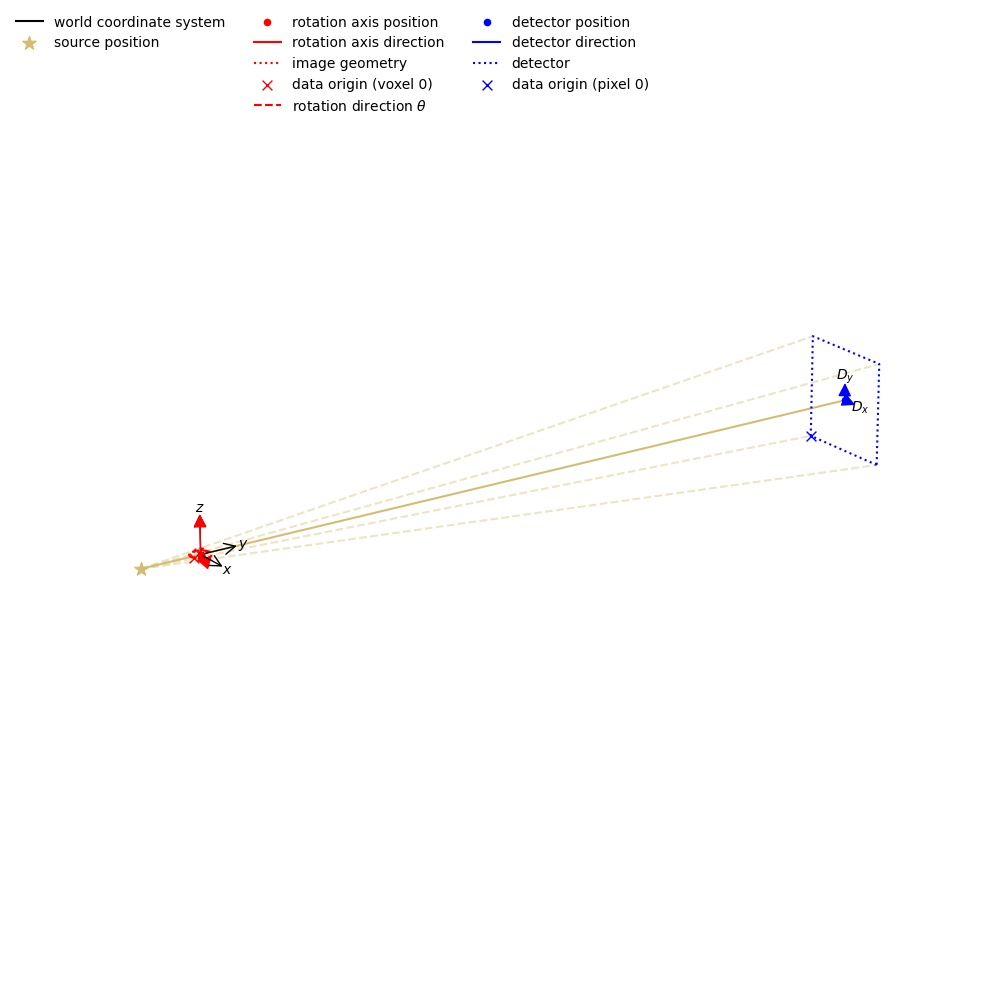

In [6]:
show_geometry(ag)

In [7]:
ig = ag.get_ImageGeometry()

In [8]:
print(ig)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x1008,y1008,z1008
voxel_size : x0.009996474264487798,y0.009996474264487798,z0.009996474264487798
center : x0,y0,z0



Data type after conversion: float32
Conversion successful


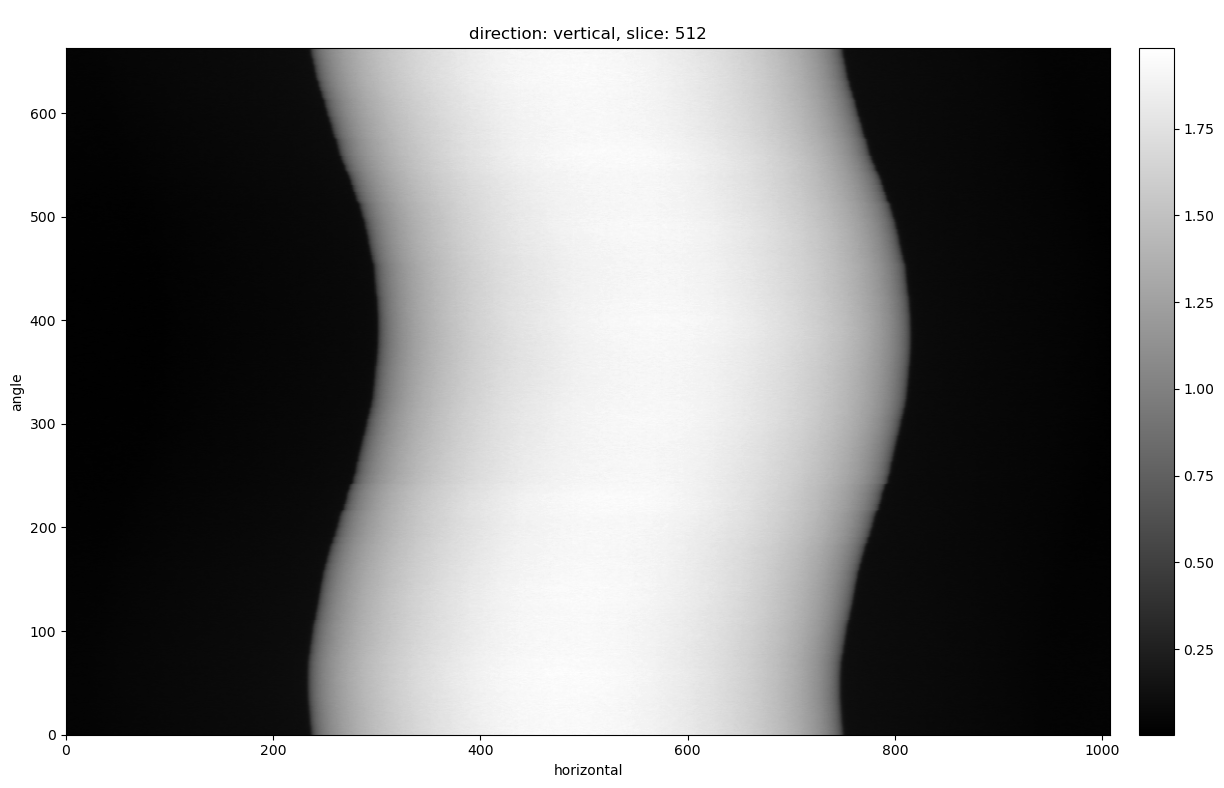

In [9]:
# Convert the data type of the array to float32
if data.array.dtype != np.float32:
    data.array = data.array.astype(np.float32)

# Re-check if the conversion is applied correctly
print("Data type after conversion:", data.array.dtype)

# Now apply the TransmissionAbsorptionConverter
try:
    #data = TransmissionAbsorptionConverter()(data)
    data = TransmissionAbsorptionConverter(white_level=data.max())(data)
 
    print("Conversion successful")
except Exception as e:
    print("Error during conversion:", e)

# If no error, you can display the image
try:
    show2D(data, slice_list=('vertical', 512))
except Exception as e:
    print("Error displaying image:", e)


In [10]:
data.reorder(order='tigre')
# Reorder the data for the 'astra' enginedata.reorder(order='astra')


In [11]:
print(data)

Number of dimensions: 3
Shape: (663, 1008, 1008)
Axis labels: ('angle', 'vertical', 'horizontal')



In [12]:
print(data.geometry);

3D Cone-beam tomography
System configuration:
	Source position: [  0.        , -77.99027252,   0.        ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [  0.        , 912.83552748,   0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1008 1008]
	Pixel size: [0.127 0.127]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 663
	Angles 0-20 in degrees:
[0.45483258, 0.6822489 , 0.90966517, 1.591914  , 1.8193303 , 2.0467467 ,
 2.274163  , 2.7289956 , 3.4112444 , 4.0934935 , 4.548326  , 5.457991  ,
 5.6854076 , 6.14024   , 6.5950727 , 6.822489  , 7.0499053 , 7.2773213 ,
 7.7321544 , 7.9595704 ]
Distances in units: units distance


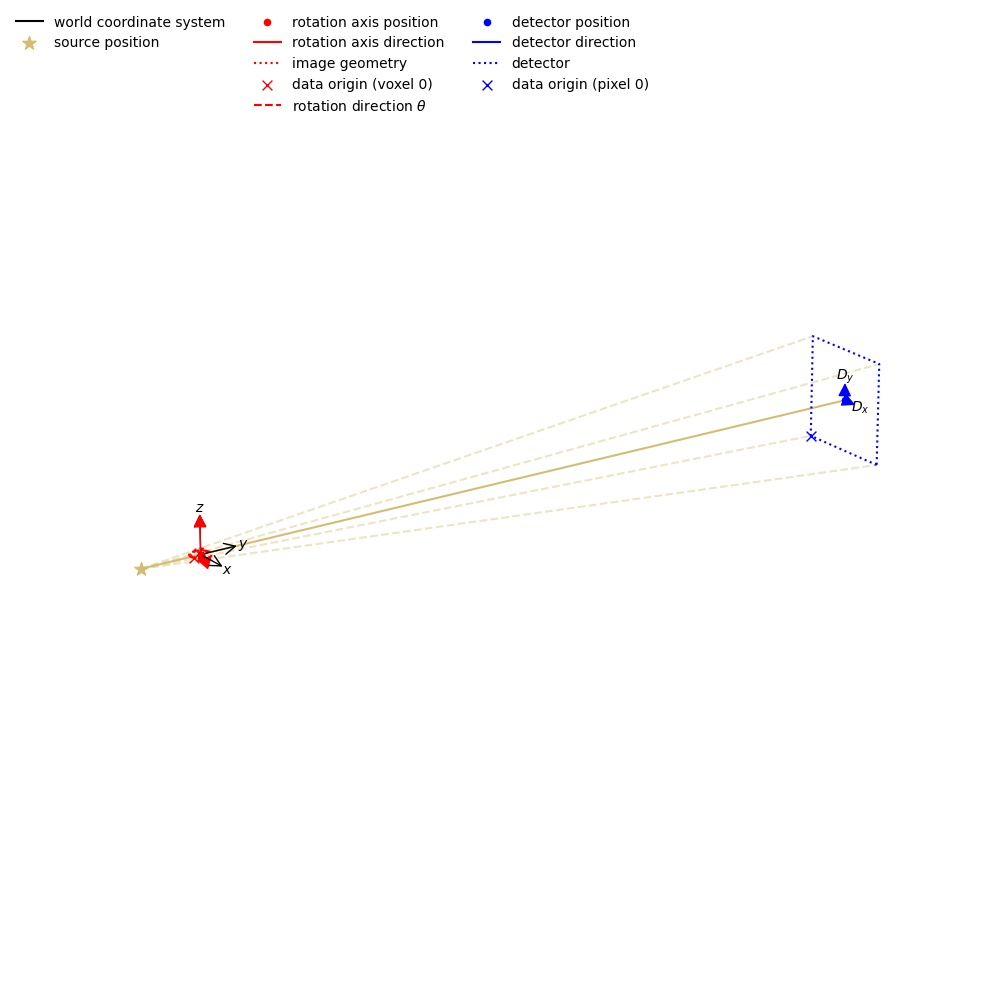

Saved image as C:\Users\snn23kfl\missing_angles_data\geometry.png


<Figure size 640x480 with 0 Axes>

In [13]:
# Plot and save the geometry
fname = os.path.join(output_directory, "geometry.png");
show_geometry(data.geometry).save(fname);

In [14]:
# Set up logging for detailed output
logging.basicConfig(level=logging.WARNING)
cil_log_level = logging.getLogger('cil.processors')
cil_log_level.setLevel(logging.DEBUG)

DEBUG:cil.processors.CofR_image_sharpness:Initial search:
DEBUG:cil.processors.CofR_image_sharpness:search range is 252
DEBUG:cil.processors.CofR_image_sharpness:initial binning is 8


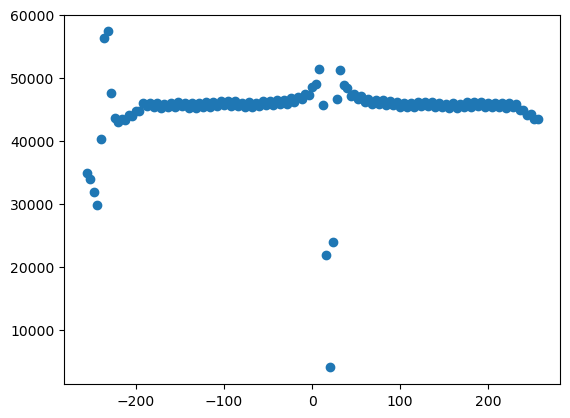

DEBUG:cil.processors.CofR_image_sharpness:fine search starting at 0.198850
DEBUG:cil.processors.CofR_image_sharpness:GSS between 0.178857 and 0.218843
INFO:cil.processors.CofR_image_sharpness:evaluated 17 points


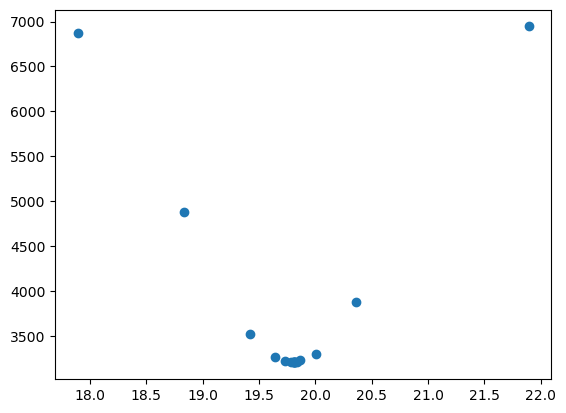

INFO:cil.processors.CofR_image_sharpness:Centre of rotation correction found using image_sharpness
INFO:cil.processors.CofR_image_sharpness:backend FBP/FDK tigre
INFO:cil.processors.CofR_image_sharpness:Calculated from slice: centre
INFO:cil.processors.CofR_image_sharpness:Centre of rotation shift = 19.813832 pixels
INFO:cil.processors.CofR_image_sharpness:Centre of rotation shift = 0.198068 units at the object
INFO:cil.processors.CofR_image_sharpness:Return new dataset with centred geometry


FDK recon

Input Data:
	angle: 663
	vertical: 1008
	horizontal: 1008

Reconstruction Volume:
	vertical: 1008
	horizontal_y: 1008
	horizontal_x: 1008

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False

FDK recon

Input Data:
	angle: 663
	vertical: 1008
	horizontal: 1008

Reconstruction Volume:
	vertical: 1008
	horizontal_y: 1008
	horizontal_x: 1008

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



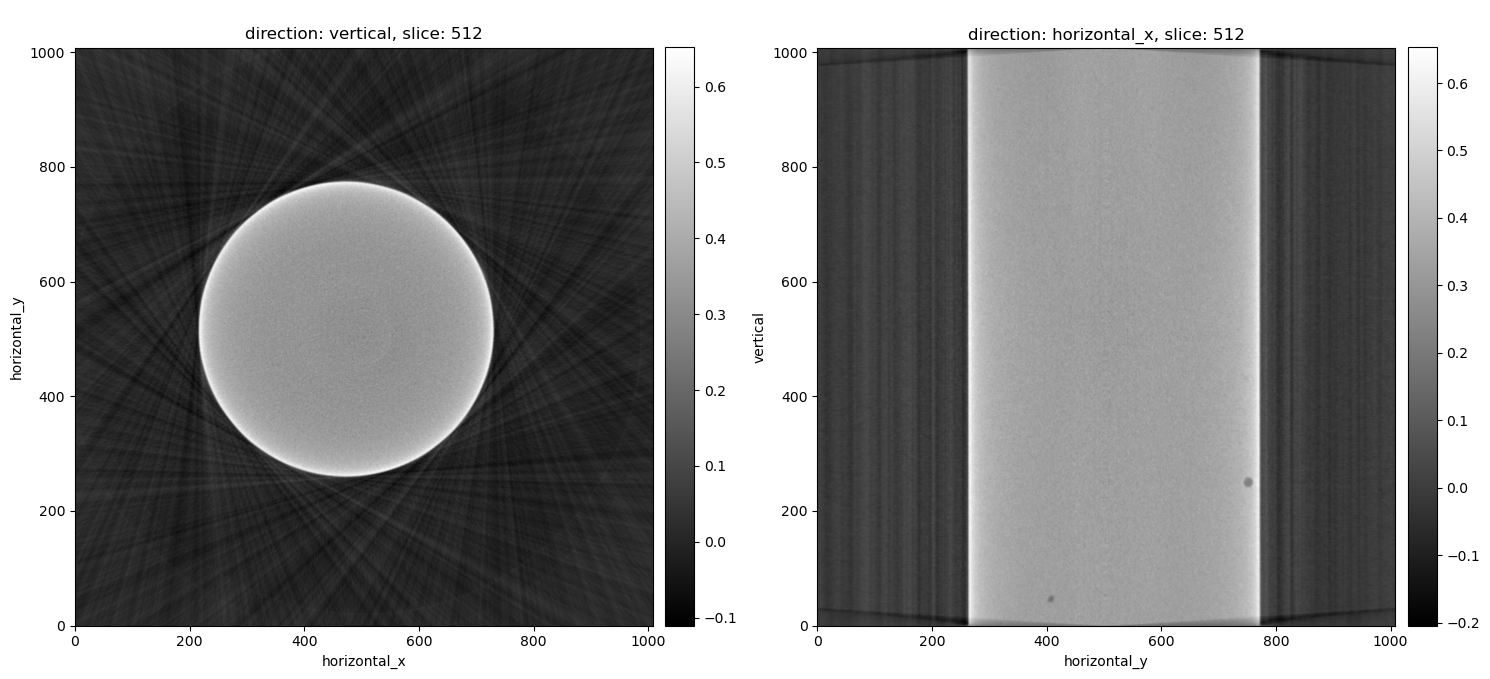

In [15]:
# Create the CentreOfRotationCorrector processor using image sharpness
processor = CentreOfRotationCorrector.image_sharpness(slice_index='centre', backend='tigre')

# Set the input data
processor.set_input(data)

# Get the output data with corrected center of rotation
data_centred = processor.get_output()

# Proceed with FDK reconstruction using the corrected data
fdk = FDK(data_centred, ig)
recon = fdk.run()
recon_fdk = fdk.run()
# Display the reconstructed image
show2D(recon_fdk, slice_list=[('vertical', 512), ('horizontal_x', 512)])

In [16]:
# Save the reconstructed volume as .mha
recon_array = recon.as_array()

In [17]:
# Convert the numpy array to SimpleITK image
sitk_image = sitk.GetImageFromArray(recon_array)

In [18]:
# Set the spacing (voxel size) if needed, for example:
sitk_image.SetSpacing((ig.voxel_size_y, ig.voxel_size_x, ig.voxel_size_z))

#output_directory = 'C:/Users/snn23kfl/missing_angles_data'
# Save the FDK reconstructed volume as .mha
recon_fdk_array = recon_fdk.as_array()
sitk_image_fdk = sitk.GetImageFromArray(recon_fdk_array)
sitk_image_fdk.SetSpacing((ig.voxel_size_y, ig.voxel_size_x, ig.voxel_size_z))
output_path_fdk = os.path.join(output_directory, 'reconstructed_fdk-full.mha')
sitk.WriteImage(sitk_image_fdk, output_path_fdk)
print(f"FDK reconstructed volume saved as {output_path_fdk}")

FDK reconstructed volume saved as C:/Users/snn23kfl/missing_angles_data\reconstructed_fdk-full.mha


In [19]:
islicer(data_centred, direction='angle', origin="upper-left");

In [20]:
scaling_factor = 1;
roi_size = [1008, 1008, 980];

Voxel size: 0.009996474264487796 0.009996474264487796 0.009996474264487796
FDK recon

Input Data:
	angle: 663
	vertical: 1008
	horizontal: 1008

Reconstruction Volume:
	vertical: 980
	horizontal_y: 1008
	horizontal_x: 1008

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



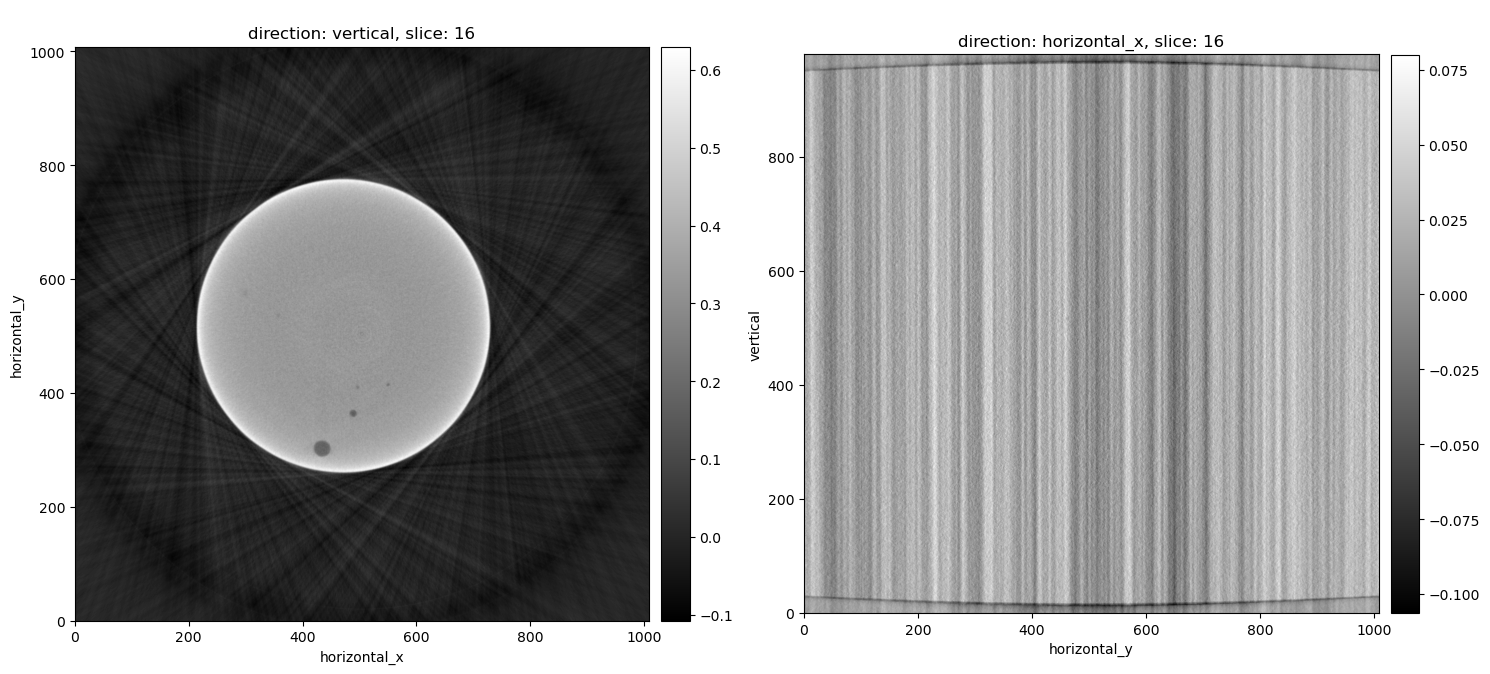

In [21]:
start = time.time();

# Prepare the data for Tigre
data_centred.reorder(order='tigre');

# Reconstruct using FDK
ig = data_centred.geometry.get_ImageGeometry();

# Change the number of voxels in the reconstructed volume if a ROI is in use
if roi_size is not None:
    ig.voxel_num_x = roi_size[0];
    ig.voxel_num_y = roi_size[1];
    ig.voxel_num_z = roi_size[2];

# Apply a scaling factor if binning is in use
if scaling_factor != 1:
    ig.voxel_num_x = round(ig.voxel_num_x / scaling_factor);
    ig.voxel_num_y = round(ig.voxel_num_y / scaling_factor);
    ig.voxel_num_z = round(ig.voxel_num_z / scaling_factor);

    ig.voxel_size_x *= scaling_factor;
    ig.voxel_size_y *= scaling_factor;
    ig.voxel_size_z *= scaling_factor;

# Show the reconstructed volume voxel size
print("Voxel size:", ig.voxel_size_x, ig.voxel_size_y, ig.voxel_size_z);

# Instantiate the reconstruction algorithm
reconstruction_algorithm = FDK(data_centred, ig);

# To save memory, apply the filter in place
#reconstruction_algorithm.set_filter_inplace(True);

# Perform the actual CT reconstruction
recons_FDK_cil = reconstruction_algorithm.run();

show2D(recons_FDK_cil, slice_list=[('vertical', 16), ('horizontal_x', 16)])
stop = time.time();
#runtime, unit = getRuntime(start, stop);
#print("Execution time:", "{0:0.2f}".format(runtime), unit);

In [22]:
# Release memory
#del data_centred;

In [23]:
import os
import numpy as np
from tifffile import imwrite

# Define the path where TIFF files will be saved
save_base_path = os.getcwd()
output_directory = 'C:/Users/snn23kfl/missing_angles_data'  # Specified output directory
output_path = 'CT_data'  # Define or modify this as needed

save_path = os.path.join(save_base_path, output_directory, output_path)
print("The CT data will be saved in:", save_path)

if not os.path.isdir(save_path):
    os.makedirs(save_path)

# The line below does not work with a MHD file and ImageJ
# TIFFWriter(data=recons_FDK_cil, file_name=os.path.join(save_path, "out")).write()

# The code below works with a MHD file and ImageJ
for i, img in enumerate(recons_FDK_cil.as_array()):
    fname = os.path.join(save_path, "out_idx_" + str(i).zfill(4) + ".tiff")
    imwrite(fname, np.flipud(img).astype(np.float32))


The CT data will be saved in: C:/Users/snn23kfl/missing_angles_data\CT_data


In [24]:
fname_mhd = os.path.join(output_directory, output_path + ".mhd");
f = open(fname_mhd, "w");

f.write("ObjectType = Image\n");
f.write("NDims = 3\n");
f.write("DimSize = " + str(ig.voxel_num_x) + " " + str(ig.voxel_num_y) + " " + str(ig.voxel_num_z) + "\n");
f.write("ElementType = MET_FLOAT\n");
f.write("ElementSpacing = " + str(ig.voxel_size_x) + " " + str(ig.voxel_size_y) + " " + str(ig.voxel_size_z) + "\n");
f.write("ElementByteOrderMSB = False\n");
f.write("ElementDataFile = " + output_path + "/out_idx_%04d.tiff 0 " + str(ig.voxel_num_z) + " 1");

f.close();

In [25]:
 #Base directory where the "Full Reconstruct" folder will be created

# Define the save path as a new directory called "Full Reconstruct" within the base directory
save_path = os.path.join(output_directory, "Reconstrut-980")

# Check if the save path directory exists, if not, create it
if not os.path.isdir(save_path):
    os.makedirs(save_path)

# Assuming `recons_FDK_cil_cropped` is the data to be saved
# The data is saved as a TIFF file named "out.tif" inside the "Full Reconstruct" folder
TIFFWriter(data=recons_FDK_cil, file_name=os.path.join(save_path, "out.tif")).write()